In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
import PIL
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from sklearn.model_selection import KFold
from tqdm import tqdm

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

import os
import shutil
import random
pd.set_option('display.max_rows', 500)


# Section 1 - Model conversion

## Build [VGG Face Descriptor Model](http://www.robots.ox.ac.uk/~vgg/software/vgg_face/) architecture

<img src="architecture.png">



### Steps 
- Create the model layers in tensorflow
- Parse matlab model weights of VGG Face Model to tensorflow model

In [2]:

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), name= 'conv1_1'))
model.add(Activation('relu', name='relu1_1'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), name= 'conv1_2'))
model.add(Activation('relu', name='relu1_2'))
model.add(MaxPooling2D((2,2), strides=(2,2), name='pool1'))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), name= 'conv2_1'))
model.add(Activation('relu', name='relu2_1'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), name= 'conv2_2'))
model.add(Activation('relu', name='relu2_2'))
model.add(MaxPooling2D((2,2), strides=(2,2), name='pool2'))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), name= 'conv3_1'))
model.add(Activation('relu', name='relu3_1'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), name= 'conv3_2'))
model.add(Activation('relu', name='relu3_2'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), name= 'conv3_3'))
model.add(Activation('relu', name='relu3_3'))
model.add(MaxPooling2D((2,2), strides=(2,2), name='pool3'))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), name= 'conv4_1'))
model.add(Activation('relu', name='relu4_1'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), name= 'conv4_2'))
model.add(Activation('relu', name='relu4_2'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), name= 'conv4_3'))
model.add(Activation('relu', name='relu4_3'))
model.add(MaxPooling2D((2,2), strides=(2,2), name='pool4'))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), name= 'conv5_1'))
model.add(Activation('relu', name='relu5_1'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), name= 'conv5_2'))
model.add(Activation('relu', name='relu5_2'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), name= 'conv5_3'))
model.add(Activation('relu', name='relu5_3'))
model.add(MaxPooling2D((2,2), strides=(2,2), name='pool5'))

model.add(Convolution2D(4096, (7, 7), name= 'fc6'))
model.add(Activation('relu', name='relu6'))
model.add(Dropout(0.5, name='dropout6'))
model.add(Convolution2D(4096, (1, 1), name= 'fc7'))
model.add(Activation('relu', name='relu7'))
model.add(Dropout(0.5, name='dropout7'))
model.add(Convolution2D(2622, (1, 1), name= 'fc8'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Activation('softmax', name= 'softmax'))

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
relu1_1 (Activation)         (None, 224, 224, 64)      0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
relu1_2 (Activation)         (None, 224, 224, 64)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0

### download -> load matlab model, parse weights to the tensorflow architecture above

In [4]:
#!wget https://m-training.s3-us-west-2.amazonaws.com/dlchallenge/vgg_face_matconvnet.tar.gz

In [5]:
if os.path.exists('vgg_face_matconvnet'):
        shutil.rmtree('vgg_face_matconvnet')
    
!tar -xf vgg_face_matconvnet.tar.gz

In [6]:
from scipy.io import loadmat
data = loadmat('vgg_face_matconvnet/data/vgg_face.mat', matlab_compatible=False, struct_as_record=False)
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Oct 13 16:54:01 2015',
 '__version__': '1.0',
 '__globals__': [],
 'net': array([[<scipy.io.matlab.mio5_params.mat_struct object at 0x7ff94ac53a00>]],
       dtype=object)}

In [7]:
net = data['net'][0][0]
ref_model_layers = net.layers
ref_model_layers.shape

(1, 39)

In [8]:
## parse layer data from matlab model object
ref_model_layers = ref_model_layers[0]
for layer in ref_model_layers:
    print(layer[0][0].name)

['conv1_1']
['relu1_1']
['conv1_2']
['relu1_2']
['pool1']
['conv2_1']
['relu2_1']
['conv2_2']
['relu2_2']
['pool2']
['conv3_1']
['relu3_1']
['conv3_2']
['relu3_2']
['conv3_3']
['relu3_3']
['pool3']
['conv4_1']
['relu4_1']
['conv4_2']
['relu4_2']
['conv4_3']
['relu4_3']
['pool4']
['conv5_1']
['relu5_1']
['conv5_2']
['relu5_2']
['conv5_3']
['relu5_3']
['pool5']
['fc6']
['relu6']
['dropout6']
['fc7']
['relu7']
['dropout7']
['fc8']
['softmax']


In [9]:
## look through tensorflow architecure created above
num_of_ref_model_layers = ref_model_layers.shape[0]
base_model_layer_names = [layer.name for layer in model.layers]
for layer in model.layers:
    layer_name = layer.name
    try:
        print(layer_name,": ",layer.weights[0].shape)
    except:
        print("",end='')


conv1_1 :  (3, 3, 3, 64)
conv1_2 :  (3, 3, 64, 64)
conv2_1 :  (3, 3, 64, 128)
conv2_2 :  (3, 3, 128, 128)
conv3_1 :  (3, 3, 128, 256)
conv3_2 :  (3, 3, 256, 256)
conv3_3 :  (3, 3, 256, 256)
conv4_1 :  (3, 3, 256, 512)
conv4_2 :  (3, 3, 512, 512)
conv4_3 :  (3, 3, 512, 512)
conv5_1 :  (3, 3, 512, 512)
conv5_2 :  (3, 3, 512, 512)
conv5_3 :  (3, 3, 512, 512)
fc6 :  (7, 7, 512, 4096)
fc7 :  (1, 1, 4096, 4096)
fc8 :  (1, 1, 4096, 2622)


In [10]:
## look through the layers in matlab model -- same
for i in range(num_of_ref_model_layers):
    ref_model_layer = ref_model_layers[i][0,0].name[0]
    
    try:
        weights = ref_model_layers[i][0,0].weights[0,0]
        print(ref_model_layer,": ",weights.shape)
    except:
        #print(ref_model_layer)
        print("",end='')

conv1_1 :  (3, 3, 3, 64)
conv1_2 :  (3, 3, 64, 64)
conv2_1 :  (3, 3, 64, 128)
conv2_2 :  (3, 3, 128, 128)
conv3_1 :  (3, 3, 128, 256)
conv3_2 :  (3, 3, 256, 256)
conv3_3 :  (3, 3, 256, 256)
conv4_1 :  (3, 3, 256, 512)
conv4_2 :  (3, 3, 512, 512)
conv4_3 :  (3, 3, 512, 512)
conv5_1 :  (3, 3, 512, 512)
conv5_2 :  (3, 3, 512, 512)
conv5_3 :  (3, 3, 512, 512)
fc6 :  (7, 7, 512, 4096)
fc7 :  (1, 1, 4096, 4096)
fc8 :  (1, 1, 4096, 2622)


In [11]:
## setting weights
for i in range(num_of_ref_model_layers):
    ref_model_layer = ref_model_layers[i][0,0].name[0]
    if ref_model_layer in base_model_layer_names:
        #we just need to set convolution and fully connected weights
        if ref_model_layer.find("conv") == 0 or ref_model_layer.find("fc") == 0:
            print(i,". ",ref_model_layer)
            base_model_index = base_model_layer_names.index(ref_model_layer)
            
            weights = ref_model_layers[i][0,0].weights[0,0]
            bias = ref_model_layers[i][0,0].weights[0,1]
            
            model.layers[base_model_index].set_weights([weights, bias[:,0]])


0 .  conv1_1
2 .  conv1_2
5 .  conv2_1
7 .  conv2_2
10 .  conv3_1
12 .  conv3_2
14 .  conv3_3
17 .  conv4_1
19 .  conv4_2
21 .  conv4_3
24 .  conv5_1
26 .  conv5_2
28 .  conv5_3
31 .  fc6
34 .  fc7
37 .  fc8


In [12]:
## save model weights - 
if os.path.exists('vgg-face-weights.h5'):
        os.remove('vgg-face-weights.h5')
model.save_weights('vgg-face-weights.h5')

# Section 2 - Data Analysis

- Download the datasets
- Create a dataset by combining Aligned and Valid, move files to their corresponding age and gender folders
- Look at # of subjects by age and gender
- Based on a few articles on skull structure by age, group subjects by decade of their age, AND look at data distribution
- Stratified sampling by age and gender to create train/validation/test sets 70/10/20 split
- Each folder has age decade and gender folders of images
- Display images for female and male by age decade
- Create image generator
    - Dataset is centered face images 
    - Only sensible augmentations are normalizing pixel values,random horizontal flips, random rotations

In [13]:
## comment/uncomment to download the dataset
#!wget https://s3.amazonaws.com/matroid-web/datasets/agegender_cleaned.tar.gz

In [14]:
if os.path.exists('combined'):
        shutil.rmtree('combined')
    
!tar -xf agegender_cleaned.tar.gz

In [15]:
data_dir = 'combined/'
train_files = os.listdir(data_dir)

sub_dir1 = 'combined/aligned/'
sub_dir2 = 'combined/valid/'

target_dir = 'combined/full_data/'
if os.path.exists(target_dir):
    shutil.rmtree(target_dir)
    
! mkdir 'combined/full_data/'

data_deets = pd.DataFrame(columns = ['Cohort', 'size'])
## combine common age and gender folders into one from the two subdir
for i in os.listdir(sub_dir1):
    s = 'combined/full_data/' + i + '/'
    s1 = sub_dir1 + i + '/'
    s2 = sub_dir2 + i + '/'
    
    if os.path.exists(s):
        shutil.rmtree(s)
    
    os.mkdir(s)
    
    file_names = os.listdir(s1)
    sz = len(file_names)
    for file_name in file_names:
        shutil.move(os.path.join(s1, file_name), s)
        
    file_names = os.listdir(s2)
    for file_name in file_names:
        shutil.move(os.path.join(s2, file_name), s)
    sz = sz + len(file_names)
    df_length = len(data_deets)
    data_deets.loc[df_length] = [i,sz]

shutil.rmtree('combined/aligned')
shutil.rmtree('combined/valid')

In [16]:
data_deets[['cohort_age','cohort_gender']] = data_deets.Cohort.str.split("_",expand=True) 
data_deets = data_deets.pivot(index='cohort_age', columns='cohort_gender', values='size').reset_index()
data_deets['cohort_age'] = data_deets['cohort_age'].astype(int)

In [17]:
## age labels
## a quick glance shows more or less equal dist in male and female proportions in each age cohort
## later age groups like age 70, 68 etc have fewer females
data_deets

cohort_gender,cohort_age,F,M
0,1,270,270
1,2,270,270
2,3,270,209
3,4,270,208
4,5,270,207
5,6,270,207
6,7,253,200
7,8,253,199
8,9,253,199
9,10,253,199


In [18]:
## for simplicity group age by <10, <20, <30,<40,<50,<60
## based on research in this paper
## https://www.sciencedirect.com/science/article/pii/S111086651100003X

age_bins = [-1,9,19,29,39,49,59,69]
labels = ['{} - {}'.format(i + 1, j) for i, j in zip(age_bins[:-1], age_bins[1:])] 
data_deets['age_range'] = pd.cut(data_deets.cohort_age, 
                                  bins=age_bins, 
                                  labels=labels, 
                                  right=True, 
                                  include_lowest=True)

In [19]:
data_deets[['age_range','M','F']].groupby('age_range').sum()

cohort_gender,M,F
age_range,,
0 - 9,1969,2379
10 - 19,2102,2584
20 - 29,2493,2482
30 - 39,2487,2479
40 - 49,2471,2488
50 - 59,2469,2348
60 - 69,2787,1249


In [20]:
## looks fairly well distribute with the exception of F in 60 to 69 age range

In [21]:
## Stratified sampling by age and gender to create train and test sets
## do this by moving 20 percent of images from each age-gender folder to test
## moving 10 percent of the images from each-gender folder validation folder
## remaining 80% to age-gender folder to train folder
## this should yield ~ 3350 Male and 3200 Female subjects in test set
## and ~ 13500 Male and 12800 Female subjects in training set

## make directory train/valid/test
target_dir = 'combined/train_data/'
if os.path.exists(target_dir):
    shutil.rmtree(target_dir)
os.mkdir(target_dir)

target_dir = 'combined/test_data/'
if os.path.exists(target_dir):
    shutil.rmtree(target_dir)
os.mkdir(target_dir)

target_dir = 'combined/val_data/'
if os.path.exists(target_dir):
    shutil.rmtree(target_dir)
os.mkdir(target_dir)

In [22]:
split_data_dir = ['combined/test_data/', 'combined/train_data/', 'combined/val_data/']

## create directory tree
for k in split_data_dir:
    for i in range(1,8):
        for j in ['F','M']:
            temp_dir = k + str(i)+'_'+j+'/'
            if os.path.exists(temp_dir):
                shutil.rmtree(temp_dir)
            os.mkdir(temp_dir)

In [23]:
full_data_dir = 'combined/full_data/'
test_subjects = 0
train_subject = 0
val_subjects = 0

## move files around
for j in os.listdir(full_data_dir):
    s = j.split('_')
    t = (int(np.ceil(int(s[0])/10)))
    train_target_dr = 'combined/train_data/'+ str(t) + '_'+ s[1] + '/'
    val_target_dr = 'combined/val_data/'+ str(t) + '_'+ s[1] + '/'
    test_target_dr = 'combined/test_data/'+ str(t) + '_' + s[1] + '/'
    source = full_data_dir + j +'/'
    files = os.listdir(source)
    len_test = int(len(files)*0.2)
    len_val = int(len(files)*0.1)
    test_files = random.sample(files, len_test)
    for k in test_files:
        shutil.move(os.path.join(source, k), test_target_dr)
        test_subjects = test_subjects +1
    files = os.listdir(source)
    val_files = random.sample(files, len_val)
    for k in val_files:
        shutil.move(os.path.join(source, k), val_target_dr)
        val_subjects = val_subjects +1    
    for k in os.listdir(source):
        shutil.move(os.path.join(source, k), train_target_dr)
        train_subject = train_subject + 1
    

In [24]:
## count sizes
print(test_subjects)
print(val_subjects)
print(train_subject)

6592
3273
23253


In [25]:
shutil.rmtree('combined/full_data')

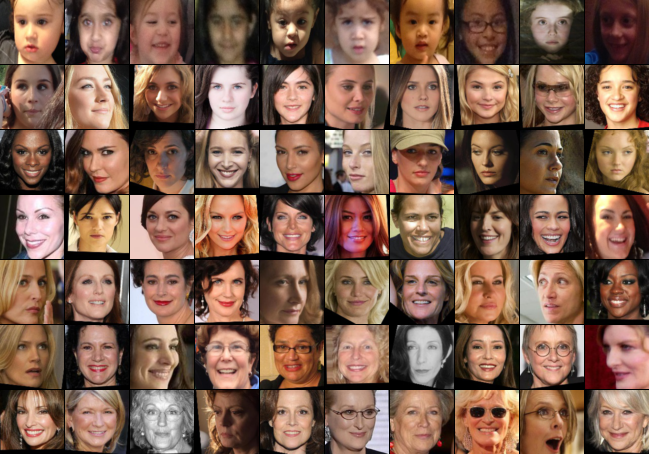

In [26]:
## display 10 images from each group - Female
## each row has ten subjects from a given decade
## decade increasing as you go down the rows

sdata_dir = 'combined/train_data/'

mosaic = PIL.Image.new(mode='RGB'
                       , size=(64*10 + (9)
                               , 64*7 + (6)))

for i in range(0,7):
        temp_dir = sdata_dir + str(i+1)+'_'+'F'+'/'
        files =  random.sample(os.listdir(temp_dir), 10)
        iy = 0
        for j in files:
            img = mpimg.imread(temp_dir+j)
            img = PIL.Image.fromarray(img)
            img = img.resize((64, 64), resample=PIL.Image.BILINEAR)
            mosaic.paste(img, (iy*64 + iy, 
                           i*64 + i))
            iy = iy+1

display(mosaic)

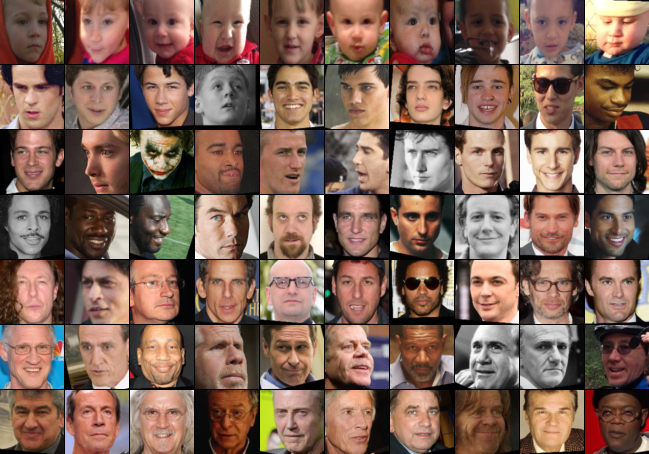

In [27]:
## display 10 images from each group - Male
## each row has ten subjects from a given decade
## decade increasing as you go down the rows

sdata_dir = 'combined/train_data/'

mosaic = PIL.Image.new(mode='RGB'
                       , size=(64*10 + (9)
                               , 64*7 + (6)))

for i in range(7):
        temp_dir = sdata_dir + str(i+1)+'_'+'M'+'/'
        files =  random.sample(os.listdir(temp_dir), 10)
        iy = 0
        for j in files:
            img = mpimg.imread(temp_dir+j)
            img = PIL.Image.fromarray(img)
            img = img.resize((64, 64), resample=PIL.Image.BILINEAR)
            mosaic.paste(img, (iy*64 + iy, 
                           i*64 + i))
            iy = iy+1

display(mosaic)

## create trian/validation data for generator

In [28]:
data_dir = 'combined/train_generator/'
! mkdir 'combined/train_generator/'
! mkdir 'combined/train_generator/Male/'
! mkdir 'combined/train_generator/Female/'

for j in os.listdir('combined/train_data/'):
    s = j.split('_')
    if s[1]=='F':    
        source = 'combined/train_data/' + j +'/'
        files = os.listdir(source)
        for k in files:
            shutil.move(os.path.join(source, k), 'combined/train_generator/Female/')
    if s[1]=='M':    
        source = 'combined/train_data/' + j +'/'
        files = os.listdir(source)
        for k in files:
            shutil.move(os.path.join(source, k), 'combined/train_generator/Male/' )
shutil.rmtree('combined/train_data')

In [29]:
data_dir = 'combined/val_generator/'
! mkdir 'combined/val_generator/'
! mkdir 'combined/val_generator/Male/'
! mkdir 'combined/val_generator/Female/'

for j in os.listdir('combined/val_data/'):
    s = j.split('_')
    if s[1]=='F':    
        source = 'combined/val_data/' + j +'/'
        files = os.listdir(source)
        for k in files:
            shutil.move(os.path.join(source, k), 'combined/val_generator/Female/')
    if s[1]=='M':    
        source = 'combined/val_data/' + j +'/'
        files = os.listdir(source)
        for k in files:
            shutil.move(os.path.join(source, k), 'combined/val_generator/Male/' )
shutil.rmtree('combined/val_data')

In [30]:
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

## some additional data augmentation
## images are quite centered so not much augmentation required other than rotation and horizontal flips maybe
training_datagen = ImageDataGenerator(
    rescale = 1./255
    , rotation_range=40
#    , width_shift_range=0.2 
#    , height_shift_range=0.2 
#    , zoom_range=0.2
    , horizontal_flip=True
    , fill_mode='nearest'
)

## utilize the new directory structure to infer classes
train_generator = training_datagen.flow_from_directory(
    'combined/train_generator/'
    , target_size=(224,224)
    , class_mode='binary'
    , batch_size=256
)

Found 23253 images belonging to 2 classes.


In [31]:
## utilize the new directory structure to infer classes
val_generator = training_datagen.flow_from_directory(
    'combined/val_generator/'
    , target_size=(224,224)
    , class_mode='binary'
    , batch_size=64
)

Found 3273 images belonging to 2 classes.


# Section 3 - Transfer Learning using VGG Face for Gender

- remove fc8
- freeze all layers
- flatten fc7, and add a dense layer(i.e. fully connected layer) with 1024 neurons
- add a neuron with sigmoid activation for binary classification
- top layers trainable
- Training for a few epochs 
    - Optimizing for AUC - measuring for seperability
    - model actully produces high AUC after 1 epoch
    - VGG Face features are very good for identifying gender - evident by fast convergence
    - save the model

In [32]:
for layer in model.layers:
    layer.trainable = False
model_transfer = Model(model.input, model.layers[-6].output)

In [33]:
last_layer = model_transfer.get_layer('relu7')
print(last_layer.output_shape)

(None, 1, 1, 4096)


In [34]:
freeze_output = last_layer.output
x = tf.keras.layers.Flatten()(freeze_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)                  
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [35]:
trans_model = tf.keras.Model(model_transfer.input, x)
trans_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_input (InputL [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
relu1_1 (Activation)         (None, 224, 224, 64)      0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
relu1_2 (Activation)         (None, 224, 224, 64)     

In [36]:
from tensorflow.keras.optimizers import RMSprop

trans_model.compile(optimizer = RMSprop(lr=0.0001)
                    , loss = 'binary_crossentropy'
                    , metrics = ['accuracy', tf.keras.metrics.AUC()])

In [37]:
history = trans_model.fit(
    train_generator
    , steps_per_epoch = 90
    , epochs = 1
    , validation_data = val_generator
    , validation_steps = 50
    , verbose = 1)

90/90 [==============================] - 3636s 40s/step - loss: 0.5157 - accuracy: 0.8961 - auc: 0.9540 - val_loss: 0.3906 - val_accuracy: 0.9191 - val_auc: 0.9769


In [51]:
## save the vgg face based gender classifier

trans_model.save("vggFaceGender")

INFO:tensorflow:Assets written to: vggFaceGender/assets


# Section 4 - Model Evaluation

- Go into each age decade - gender folder in test dataset
- Score each image 
- save the age decade, gender and the model prediction in a dataframe

- repeat the process using test time augmentations 
- test time augmentations that make sense color, hue, saturation adjustments, provides a lift

In [39]:
## go into each testing sub dir and score customers
## keep a record to tract their age decade, gender and model prediction

In [40]:
data_dir = 'combined/test_data/'

test_deets = pd.DataFrame(columns = ['Cohort_age_decade'
                                     , 'Cohort_gender' 
                                     , 'prediction'])

for j in os.listdir(data_dir):
    s = j.split('_')
    print('\nStarted scoring cohort -> Age Decade: '+s[0]+ ' & Gender: '+s[1])
    source = data_dir + j +'/'
    files = os.listdir(source)
    for k in tqdm(files):
        ## read in the image 
        img = mpimg.imread(source+k)
        img = np.array(img)
        img = tf.convert_to_tensor(img, tf.float32)
        ## normalize, reshape each image and score in the model
        img = tf.image.resize(img, [224,224])
        img = tf.cast(img, tf.float32) / 255.0
        input_arr = tf.expand_dims(img, axis=0)
        pred = trans_model.predict(input_arr, batch_size=1)[0][0]
        ## save score to the test_deets dataframe
        df_length = len(test_deets)
        test_deets.loc[df_length] = [s[0],s[1],pred]
    print('Finished cohort')
    
##
print('\n Finished scoring all test subjects')

  0%|          | 0/496 [00:00<?, ?it/s]


Started scoring cohort -> Age Decade: 5 & Gender: F


  0%|          | 0/498 [00:00<?, ?it/s]

Finished cohort

Started scoring cohort -> Age Decade: 3 & Gender: M


  0%|          | 1/560 [00:00<01:47,  5.18it/s]

Finished cohort

Started scoring cohort -> Age Decade: 7 & Gender: M


  0%|          | 1/524 [00:00<01:37,  5.39it/s]

Finished cohort

Started scoring cohort -> Age Decade: 1 & Gender: F


  0%|          | 1/452 [00:00<01:27,  5.17it/s]

Finished cohort

Started scoring cohort -> Age Decade: 6 & Gender: F


  0%|          | 0/515 [00:00<?, ?it/s]

Finished cohort

Started scoring cohort -> Age Decade: 2 & Gender: F


  0%|          | 1/496 [00:00<01:33,  5.31it/s]

Finished cohort

Started scoring cohort -> Age Decade: 4 & Gender: M


  0%|          | 1/429 [00:00<01:20,  5.31it/s]

Finished cohort

Started scoring cohort -> Age Decade: 1 & Gender: M


  0%|          | 1/221 [00:00<00:42,  5.24it/s]

Finished cohort

Started scoring cohort -> Age Decade: 7 & Gender: F


  0%|          | 1/496 [00:00<01:32,  5.34it/s]

Finished cohort

Started scoring cohort -> Age Decade: 3 & Gender: F


  0%|          | 0/489 [00:00<?, ?it/s]

Finished cohort

Started scoring cohort -> Age Decade: 5 & Gender: M


  0%|          | 1/495 [00:00<01:32,  5.36it/s]

Finished cohort

Started scoring cohort -> Age Decade: 4 & Gender: F


  0%|          | 1/426 [00:00<01:20,  5.28it/s]

Finished cohort

Started scoring cohort -> Age Decade: 2 & Gender: M


  0%|          | 1/495 [00:00<01:33,  5.29it/s]

Finished cohort

Started scoring cohort -> Age Decade: 6 & Gender: M


100%|██████████| 495/495 [01:34<00:00,  5.25it/s]

Finished cohort

 Finished scoring all test subjects


In [41]:
test_deets['target'] = np.where(test_deets['Cohort_gender']=='F', 0, 1)
test_deets.head()

,Cohort_age_decade,Cohort_gender,prediction,target
0,5,F,0.153454,0
1,5,F,0.164304,0
2,5,F,0.188943,0
3,5,F,0.412578,0
4,5,F,0.204921,0


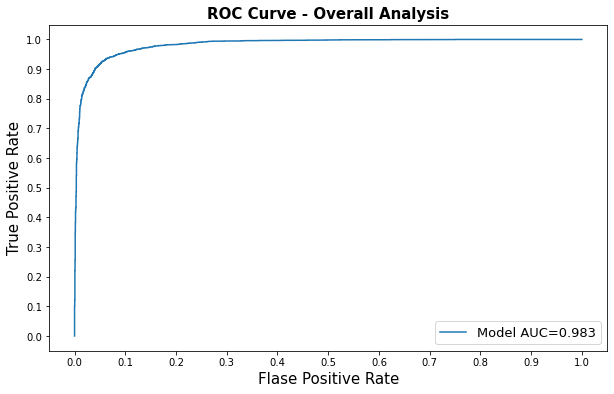

In [42]:
## overall test set performance 
from sklearn.metrics import roc_auc_score
auc_ = round(roc_auc_score(test_deets['target'], test_deets['prediction']),3)

fpr, tpr, _ = roc_curve(test_deets['target'],  test_deets['prediction'])
fig = plt.figure(figsize=(10,6))
plt.plot(fpr, 
         tpr, 
         label="Model AUC={:.3f}".format(auc_))
    
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)
    
plt.title('ROC Curve - Overall Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()

In [43]:
for i in range(1,8):
    temp = test_deets[test_deets['Cohort_age_decade']==str(i)]
    auc_ = round(roc_auc_score(temp['target'], temp['prediction']),3)
    print(auc_)

0.837
0.961
0.997
0.996
0.998
0.989
0.995


In [44]:
test_deets[['Cohort_age_decade'
            ,'Cohort_gender'
            ,'prediction']].groupby(['Cohort_age_decade'
                                     ,'Cohort_gender']).agg({'prediction':['mean','std','count']})

prediction                
                                      mean       std count
Cohort_age_decade Cohort_gender                           
1                 F               0.392833  0.102133   524
                  M               0.534128  0.101972   429
2                 F               0.287244  0.116267   515
                  M               0.610935  0.118094   426
3                 F               0.239005  0.091381   496
                  M               0.690804  0.090441   498
4                 F               0.243441  0.091762   495
                  M               0.702989  0.094270   496
5                 F               0.240180  0.089814   496
                  M               0.719009  0.087586   489
6                 F               0.277916  0.126244   452
                  M               0.711797  0.084659   495
7                 F               0.268631  0.111053   221
                  M               0.699429  0.085746   560

In [52]:
## test time augmentations 

TTA = 5

data_dir = 'combined/test_data/'

test_deets_tta = pd.DataFrame(columns = ['Cohort_age_decade'
                                         , 'Cohort_gender' 
                                         , 'prediction'])

for j in os.listdir(data_dir):
    s = j.split('_')
    print('\nStarted scoring cohort -> Age Decade: '+s[0]+ ' & Gender: '+s[1])
    source = data_dir + j +'/'
    files = os.listdir(source)
    for k in tqdm(files):
        
        img = mpimg.imread(source+k)
        img = np.array(img)
        img = tf.convert_to_tensor(img, tf.float32)
        
        pred_ls = []
        for i in range(TTA):
            
            ## Test time Augmentation
            img1 = tf.image.random_flip_left_right(img)
            img1 = tf.image.random_hue(img1, 0.01)
            img1 = tf.image.random_saturation(img1, 0.7, 1.3)
            #img1 = tf.image.random_contrast(img1, 0.8, 1.2)
            img1 = tf.image.random_brightness(img1, 0.1)
            
            
            ## normalize, reshape each image and score in the model
            img1 = tf.image.resize(img1, [224,224])
            img1 = tf.cast(img1, tf.float32) / 255.0
            
            input_arr = tf.expand_dims(img1, axis=0)
            pred = trans_model.predict(input_arr, batch_size=1)[0][0]
            pred_ls.append(pred)
        
        ## avergae the predictions
        pred = round(np.mean(pred_ls),3)
        ## save score to the test_deets dataframe
        df_length = len(test_deets_tta)
        test_deets_tta.loc[df_length] = [s[0],s[1],pred]
    print('Finished cohort')
    
##
print('\n Finished scoring all test subjects')

  0%|          | 0/496 [00:00<?, ?it/s]


Started scoring cohort -> Age Decade: 5 & Gender: F


  0%|          | 0/498 [00:00<?, ?it/s]

Finished cohort

Started scoring cohort -> Age Decade: 3 & Gender: M


  0%|          | 0/560 [00:00<?, ?it/s]

Finished cohort

Started scoring cohort -> Age Decade: 7 & Gender: M


  0%|          | 0/524 [00:00<?, ?it/s]

Finished cohort

Started scoring cohort -> Age Decade: 1 & Gender: F


  0%|          | 0/452 [00:00<?, ?it/s]

Finished cohort

Started scoring cohort -> Age Decade: 6 & Gender: F


  0%|          | 0/515 [00:00<?, ?it/s]

Finished cohort

Started scoring cohort -> Age Decade: 2 & Gender: F


  0%|          | 0/496 [00:00<?, ?it/s]

Finished cohort

Started scoring cohort -> Age Decade: 4 & Gender: M


  0%|          | 0/429 [00:00<?, ?it/s]

Finished cohort

Started scoring cohort -> Age Decade: 1 & Gender: M


  0%|          | 0/221 [00:00<?, ?it/s]

Finished cohort

Started scoring cohort -> Age Decade: 7 & Gender: F


  0%|          | 0/496 [00:00<?, ?it/s]

Finished cohort

Started scoring cohort -> Age Decade: 3 & Gender: F


  0%|          | 0/489 [00:00<?, ?it/s]

Finished cohort

Started scoring cohort -> Age Decade: 5 & Gender: M


  0%|          | 0/495 [00:00<?, ?it/s]

Finished cohort

Started scoring cohort -> Age Decade: 4 & Gender: F


  0%|          | 0/426 [00:00<?, ?it/s]

Finished cohort

Started scoring cohort -> Age Decade: 2 & Gender: M


  0%|          | 0/495 [00:00<?, ?it/s]

Finished cohort

Started scoring cohort -> Age Decade: 6 & Gender: M


100%|██████████| 495/495 [07:59<00:00,  1.03it/s]

Finished cohort

 Finished scoring all test subjects


In [53]:
test_deets_tta['target'] = np.where(test_deets_tta['Cohort_gender']=='F', 0, 1)
test_deets_tta.head()

,Cohort_age_decade,Cohort_gender,prediction,target
0,5,F,0.146,0
1,5,F,0.160,0
2,5,F,0.187,0
3,5,F,0.431,0
4,5,F,0.220,0


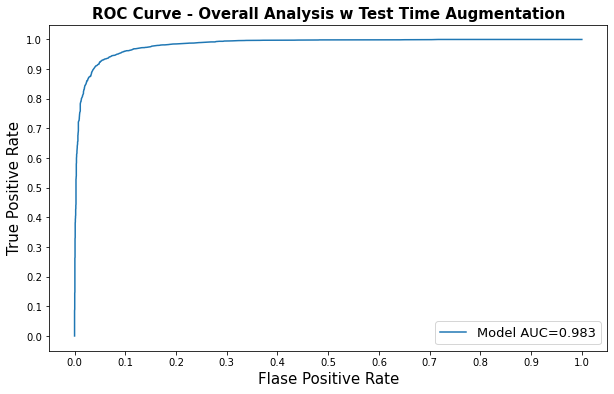

In [57]:
## overall test set performance 
from sklearn.metrics import roc_auc_score
auc_ = round(roc_auc_score(test_deets_tta['target'], test_deets_tta['prediction']),3)

fpr, tpr, _ = roc_curve(test_deets_tta['target'],  test_deets_tta['prediction'])
fig = plt.figure(figsize=(10,6))
plt.plot(fpr, 
         tpr, 
         label="Model AUC={:.3f}".format(auc_))
    
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)
    
plt.title('ROC Curve - Overall Analysis w Test Time Augmentation', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()

In [55]:
for i in range(1,8):
    temp = test_deets_tta[test_deets_tta['Cohort_age_decade']==str(i)]
    auc_ = round(roc_auc_score(temp['target'], temp['prediction']),3)
    print(auc_)

0.846
0.962
0.997
0.996
0.998
0.989
0.996


In [56]:
test_deets_tta[['Cohort_age_decade'
                ,'Cohort_gender'
                ,'prediction']].groupby(['Cohort_age_decade'
                                     ,'Cohort_gender']).agg({'prediction':['mean','std','count']})

prediction                
                                      mean       std count
Cohort_age_decade Cohort_gender                           
1                 F               0.391664  0.101049   524
                  M               0.537117  0.100752   429
2                 F               0.288229  0.116099   515
                  M               0.610751  0.116260   426
3                 F               0.241821  0.091543   496
                  M               0.694056  0.089443   498
4                 F               0.243725  0.090724   495
                  M               0.704153  0.094618   496
5                 F               0.242085  0.090669   496
                  M               0.718675  0.088365   489
6                 F               0.279210  0.124893   452
                  M               0.711479  0.082958   495
7                 F               0.269086  0.108337   221
                  M               0.699505  0.085069   560